<a href="https://colab.research.google.com/github/tri008/graffiti-demo/blob/main/graffiti_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/graffiti_streetview', output='/content/drive/MyDrive/Dataset_Graffiti',
                    seed=1337, ratio=(0.8, 0.1, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  7.53 files/s]
Copying files: 6 files [00:00, 25.24 files/s]
Copying files: 12 files [00:00, 37.87 files/s]
Copying files: 18 files [00:00, 43.93 files/s]
Copying files: 26 files [00:00, 53.35 files/s]
Copying files: 32 files [00:00, 52.35 files/s]
Copying files: 38 files [00:01, 32.51 files/s]
Copying files: 43 files [00:01, 35.69 files/s]
Copying files: 49 files [00:01, 40.86 files/s]
Copying files: 55 files [00:01, 44.43 files/s]
Copying files: 62 files [00:01, 49.86 files/s]
Copying files: 68 files [00:02, 21.40 files/s]
Copying files: 75 files [00:02, 27.61 files/s]
Copying files: 80 files [00:02, 30.82 files/s]
Copying files: 87 files [00:02, 37.74 files/s]
Copying files: 93 files [00:02, 41.70 files/s]
Copying files: 100 files [00:02, 45.91 files/s]
Copying files: 107 files [00:02, 50.63 files/s]
Copying files: 113 files [00:03, 34.13 files/s]
Copying files: 120 files [00:03, 39.81 files/s]
Copying files: 

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow import keras
from keras import backend as K

In [17]:
trainpath= '/content/drive/My Drive/Dataset_Graffiti/train'
validpath='/content/drive/My Drive/Dataset_Graffiti/val'
testpath='/content/drive/My Drive/Dataset_Graffiti/test'

Width=224
Height=224
Batch_Size=8
# Data Augumentation
# To balance the dataset and to increase the size of training nd testing dataset
# Regularization technique to minimize overfitting
# Rescaling the image is Normalizing the image
train_data_generator= ImageDataGenerator(shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         preprocessing_function=preprocess_input
                                         )

train_set = train_data_generator.flow_from_directory(trainpath,
                                                    target_size=(Width,Height),
                                                    batch_size=Batch_Size,
                                                    class_mode='binary'
                                                  )
valid_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_set = valid_data_generator.flow_from_directory(validpath,
                                                    target_size=(Width,Height),
                                                    batch_size=Batch_Size,
                                                    class_mode='binary', shuffle=False
                                                        )

test_data_generator= ImageDataGenerator()

test_set = test_data_generator.flow_from_directory(testpath,
                                                  target_size=(Width,Height),
                                                  batch_size=Batch_Size, class_mode='binary',
                                                   shuffle=False
                                                    )

# To print number of batches per epoch
print('Number of Batches per epoch train=%d, valid=%d ,test=%d' % (len(train_set), len(valid_set),len(test_set)))

Found 177 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Number of Batches per epoch train=23, valid=3 ,test=3


In [18]:
base_model_100= applications.ResNet50(include_top=False, weights='imagenet', input_shape=(Width, Height,3))
base_model_100.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [19]:
# Adding custom layers
x = base_model_100.output
# gap= sum of all elements/number of all (which ia a 1*1)
x = GlobalAveragePooling2D()(x) # To reduce the Number of parameters that feed to future FC layer which reduce the total weights and can improve training speed
# x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.3)(x) # Regularization method to minimize overfitting
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.3)(x) # Regularization method to minimize overfitting
predictions = Dense(1, activation='sigmoid')(x)

# creating the final model
model_final_100 = Model(inputs = base_model_100.input, outputs = predictions)

# Freezing first seven layers
for layer in model_final_100.layers[:-4]:
    layer.trainable = False

# compile the model
# Learning rate should be tuned
# beta1= 0.9 (first moment)
#beta2=0.999 (second moment)
#Epsilon=10-8............beta_1=0.9, beta_2=0.999
model_final_100.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"]) # Adam- Adaptive moment estimation
model_final_100.summary()
# print ('model output shape:', model_final.output_shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [20]:
# Saving the model according to the conditions
checkpoint = ModelCheckpoint("Resnet_100.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Early Stopping is a regularization method (To minimize overfitting)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

import math
# Train the model
train_100= model_final_100.fit_generator(
                                train_set,
                                steps_per_epoch = train_set.samples//train_set.batch_size,
                                epochs = 40,
                                validation_data = valid_set,
                                validation_steps = valid_set.samples//valid_set.batch_size,
                                callbacks=[checkpoint,early])

<ipython-input-20-55b82c273d6c>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_100= model_final_100.fit_generator(


Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.7041
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to Resnet_100.h5
22/22 [==============================] - 8s 204ms/step - loss: 0.9632 - accuracy: 0.7041 - val_loss: 0.2363 - val_accuracy: 0.9375
Epoch 2/40
21/22 [===========================>..] - ETA: 0s - loss: 0.5808 - accuracy: 0.8214
Epoch 2: val_accuracy did not improve from 0.93750
22/22 [==============================] - 4s 167ms/step - loss: 0.5776 - accuracy: 0.8225 - val_loss: 0.2427 - val_accuracy: 0.8750
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8698
Epoch 3: val_accuracy did not improve from 0.93750
22/22 [==============================] - 4s 176ms/step - loss: 0.3556 - accuracy: 0.8698 - val_loss: 0.1718 - val_accuracy: 0.9375
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9112
Epoch 4: val_accuracy did not improve from 0.9

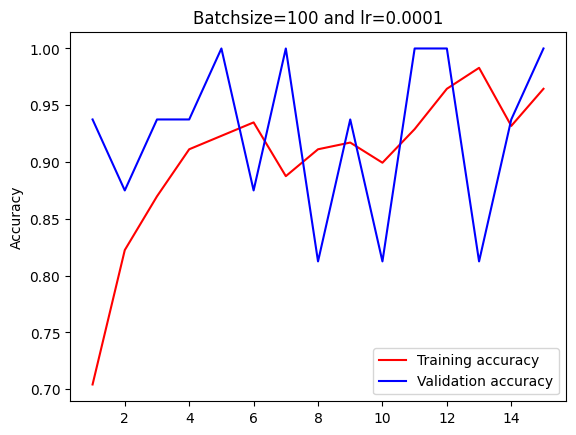

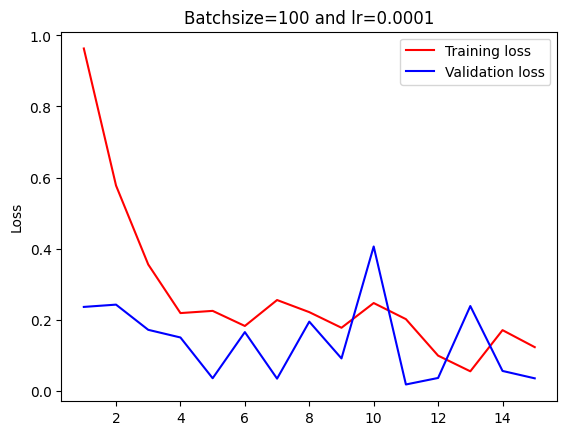

In [22]:
import matplotlib.pyplot as plt
acc = train_100.history['accuracy']
val_acc = train_100.history['val_accuracy']
loss = train_100.history['loss']
val_loss = train_100.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.ylabel("Accuracy")
plt.title('Batchsize=100 and lr=0.0001')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel("Loss")
plt.title('Batchsize=100 and lr=0.0001')
plt.legend()
plt.show()
